In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import multiprocessing
from sklearn import utils

In [2]:
base = "/content/drive/My Drive/New Brent/Tsu/Data/"
tweets_business = pd.read_csv(base + 'business.csv')
tweets_wsj = pd.read_csv(base + 'wsj.csv')
tweets_the_economist = pd.read_csv(base + 'the_economist.csv')
tweets = pd.concat([tweets_business, tweets_wsj, tweets_the_economist])

In [3]:
def standardize_text(df, text_field):
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
  df[text_field] = df[text_field].str.replace(r"http", "")
  df[text_field] = df[text_field].str.replace(r"@\S+", "") 
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9\'\`]", " ") 
  df[text_field] = df[text_field].str.replace(r"@", "at") 
  df[text_field] = df[text_field].str.lower() 
  return df

def labelize_text_ug(text_series, label):
    result = []
    prefix = label
    for index, text in zip(text_series.index, text_series):
        result.append(TaggedDocument(text.split(), [prefix + '_%s' % index]))
    return result

class Embeddings:
  def __init__(self):
    cores = multiprocessing.cpu_count()
    self.model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
  def learn(self,all_x_w2v):
    self.model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])
    for epoch in range(12):
      self.model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
      self.model_ug_sg.alpha -= 0.002
      self.model_ug_sg.min_alpha = self.model_ug_sg.alpha
    return self.model_ug_sg
  def get_index(self):
    embeddings_index = {}
    for w in self.model_ug_sg.wv.vocab.keys():
      embeddings_index[w] = self.model_ug_sg.wv[w]
    return embeddings_index
  def save(self):
    self.model_ug_sg.save('w2v_model_ug_sg_tonality.word2vec')
  def load(self):
    self.model_ug_sg = KeyedVectors.load('w2v_model_ug_sg_tonality.word2vec')

In [4]:
x = standardize_text(tweets, "tweet")['tweet']
all_x_w2v = labelize_text_ug(x, 'all')

Embeddings = Embeddings()
model = Embeddings.learn(all_x_w2v)

embeddings_index = Embeddings.get_index()

100%|██████████| 667493/667493 [00:00<00:00, 2356323.87it/s]


==============================================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


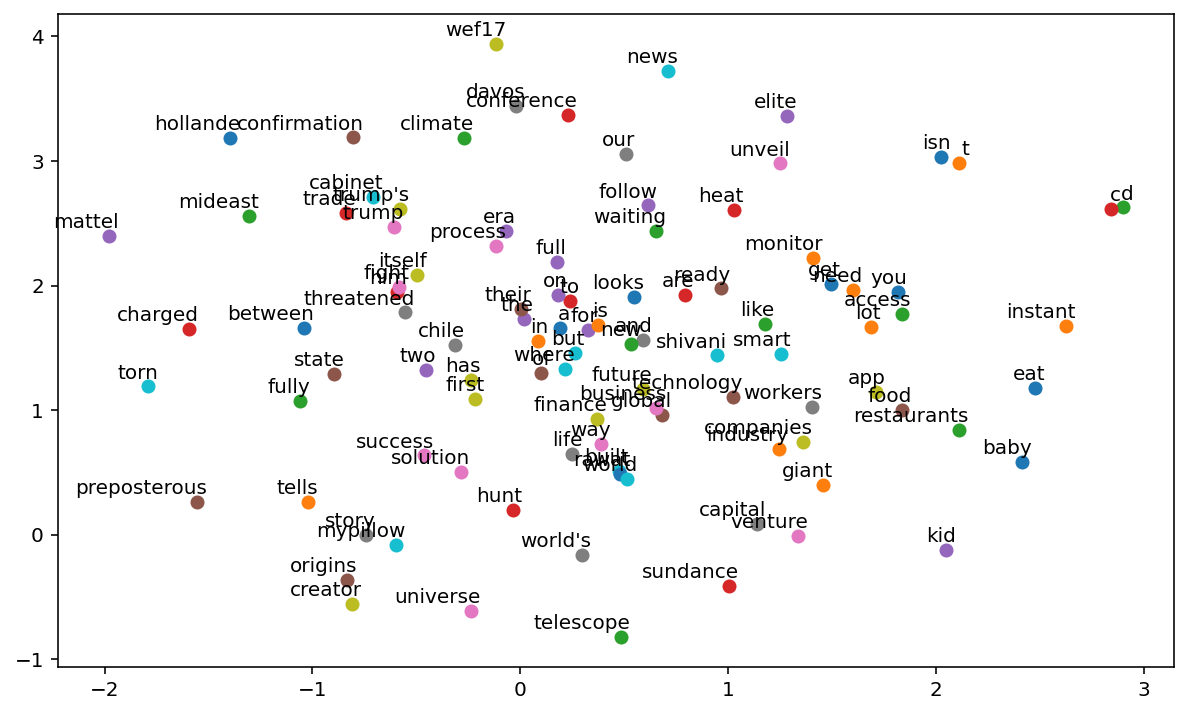

In [5]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in list(model.wv.vocab)[:100]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 6)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(model)

==================================================

In [6]:
class Tokens:
  def __init__(self):
    self.tokenizer = Tokenizer(num_words=100000)
    self.x_train_seq = None
    self.x_val_seq = None
  def hand(self,x):
    sequences = self.tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=45)
  def learn(self,x_train):
    self.tokenizer.fit_on_texts(x_train)
  def get_embedding_matrix(self, embeddings_index):
    num_words = 100000
    embedding_matrix = np.zeros((num_words, 100))
    for word, i in self.tokenizer.word_index.items():
      if i >= num_words:
        continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    return embedding_matrix
  def save(self):
    with open('tokenizer.pickle', 'wb') as handle:
      pickle.dump(self.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  def load(self):
    with open('tokenizer.pickle', 'rb') as handle:
      self.tokenizer = pickle.load(handle)

In [7]:
tweets = tweets[tweets['tweet'].str.contains('oil|brent', flags=re.IGNORECASE, regex=True)]['tweet']
embeddings_index = Embeddings.get_index()

Tokens = Tokens()
Tokens.learn(x)

x_tokens = Tokens.hand(tweets)
embedding_matrix = Tokens.get_embedding_matrix(embeddings_index)

In [8]:
print("embeddings", embeddings_index['get'])

embeddings [-0.46913332  0.13889454  0.06954027 -0.35665366  0.20731658  0.08038375
  0.58401084 -0.25155044 -0.27399534  0.06517605  0.15026963  0.40507048
  0.45874593  0.04699099 -0.39858314 -0.1099354   0.03309897 -0.00814897
  0.19237328  1.3256922   0.11506508 -0.11590613  0.16748093 -0.11528907
  0.24610822 -0.10654053  0.12469788 -0.13604103 -0.02875596  0.04217786
  0.14484105 -0.10160639 -0.15861584 -0.34660548 -0.38178837  0.09677806
  0.11755684 -0.424756   -0.00388906 -0.8937532  -0.10242172  0.28982776
 -0.1880607  -0.40418786  0.19210392  0.18107426 -0.5507041  -0.26520678
  0.23015009  0.13494493 -0.29728678  0.08172511  0.33079806  0.08346723
  0.31373584  0.07366139 -0.25970304 -0.01699501  0.38836262 -0.27319977
  0.18092802 -0.0438722   0.11547705  0.20267612  0.36502454 -0.07673217
  0.7865984   0.11073212  0.17488317 -0.18150224 -0.13129172  0.08541714
 -0.06250168  0.2783037  -0.00338085 -0.15426993  0.42834142 -0.1560844
 -0.70552915 -0.21295017  0.04583654 -0.1

In [9]:
x_tokens[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,  5959,   412,
        3483,    18, 10706,     3,  3012,   610,  4999,     9,  2118],
      dtype=int32)

In [10]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.4130336 ,  0.03531007, -0.08401667, ..., -0.24000455,
         0.23462278,  0.04172148],
       [-0.27977291,  0.04071378, -0.14312904, ..., -0.02508339,
         0.02468194,  0.2328168 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])